In [230]:
# general:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV       # hyperparam selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef  # matric for performance evaluation in training
# self-writtten:
import data_cleaner as dc  # self-writtten data cleaning functions
import ML_func as ml       # self-written ML related functions
pd.set_option('display.max_rows', 500)  # let pd.df display() 500 rows
pd.set_option('display.max_columns', 500)

# Import data & pre-processing

In [252]:
# imputed:  use 1 data to build pipeline first
x_train_imp = pd.read_csv("../clean_data/mci_wv1go_imp.csv")   
x_test_imp = pd.read_csv("../clean_data/mci_wv23_imp.csv")   
y_train = x_train_imp.pop("progress")
y_test = x_test_imp.pop("progress")

In [253]:
# standardization in training & keep the original mean & sd
# x_train, train_mean_sd = dc.standardization(x_train)
# x_test, test_mean_sd = dc.standardization(x_test)
x_train, train_imp_mean_sd = dc.standardization(x_train_imp)
x_test, test_imp_mean_sd = dc.standardization(x_test_imp)

### XGBoost

In [233]:
import xgboost as xgb
# hyperparameter selection: 
params = {
    'lambda':[1,2],               # L2 regularization
    'eta':[0.05, 0.1, 0.3],       # learning rate
    'max_depth':[3,5,6],          # tree depth 
    'tree_method':["exact", "hist"]
}
mod_xgb = xgb.XGBClassifier(booster="gbtree", objective='binary:logistic', seed=1)  
cv_xgb = GridSearchCV(
    estimator = mod_xgb, 
    param_grid=params,
    cv=10,
    scoring = 'matthews_corrcoef'  # because outcome imbalanced
)
cv_xgb.fit(x_train, y_train)       
pd.DataFrame(cv_xgb.cv_results_).sort_values("rank_test_score").head()  # GridSearch result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_eta,param_lambda,param_max_depth,param_tree_method,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
25,0.160106,0.012514,0.002576,0.000374,0.3,1,3,hist,"{'eta': 0.3, 'lambda': 1, 'max_depth': 3, 'tre...",0.298199,0.407553,0.184474,0.234868,0.469536,0.484165,0.465818,0.578831,0.457490,0.383257,0.396419,0.116546,1
18,0.208362,0.029975,0.002540,0.000255,0.1,2,3,exact,"{'eta': 0.1, 'lambda': 2, 'max_depth': 3, 'tre...",0.254478,0.526412,0.088394,0.216338,0.484165,0.319756,0.465818,0.513353,0.513353,0.383257,0.376532,0.143636,2
22,0.345405,0.023600,0.002600,0.000155,0.1,2,6,exact,"{'eta': 0.1, 'lambda': 2, 'max_depth': 6, 'tre...",0.254478,0.407553,0.047693,0.095254,0.484165,0.358891,0.540878,0.513353,0.578831,0.361029,0.364212,0.173316,3
0,0.248871,0.059307,0.002915,0.000552,0.05,1,3,exact,"{'eta': 0.05, 'lambda': 1, 'max_depth': 3, 'tr...",0.204833,0.481264,0.184092,0.086280,0.484165,0.381227,0.406566,0.441637,0.513353,0.457490,0.364091,0.142198,4
12,0.208757,0.007619,0.002378,0.000201,0.1,1,3,exact,"{'eta': 0.1, 'lambda': 1, 'max_depth': 3, 'tre...",0.160036,0.481264,0.184474,0.204833,0.406566,0.437167,0.406566,0.513353,0.457490,0.383257,0.363501,0.123818,5


In [258]:
max_iterator = 500   # num of max trees
xgb_params = ml.vote_hyperparam(cv_xgb.cv_results_, top_n=5)  # top 5 mods vote for hyperparam

# check learning curve to find best iteration:
best_it = []
for i in range(5):
    xgb_train, xgb_validate, o_train, o_validate = train_test_split(
        x_train, y_train, train_size=0.8, stratify=y_train, random_state = i*10)
    mod_xgb = xgb.XGBClassifier(booster="gbtree", objective='binary:logistic', 
                                eval_metric = 'logloss',
                                random_state=i, early_stopping_rounds = max_iterator//10,
                                n_estimators= max_iterator, 
                                **xgb_params  # use ** to unpack dict
                               ) 
    mod_xgb.fit(xgb_train, o_train, verbose=0,
                eval_set=[(xgb_train, o_train), (xgb_validate, o_validate)]) 
    results = mod_xgb.evals_result()
    best_it.append(mod_xgb.best_iteration)
#     plt.figure(figsize=(4,3))
#     plt.plot(results["validation_0"]["logloss"], label="Training loss")
#     plt.plot(results["validation_1"]["logloss"], label="Validation loss")
#     plt.axvline(best_it[-1], color="gray", label="Optimal tree number")
#     plt.xlabel("Number of trees")
#     plt.ylabel("Loss")
#     plt.legend()
print(f"Best iteration for each round: {best_it}; mean={sum(best_it)/5}")
xgb_it = round(sum(best_it)/5)# choose 72 as optimal iteration

Best iteration for each round: [41, 104, 96, 47, 71]; mean=71.8


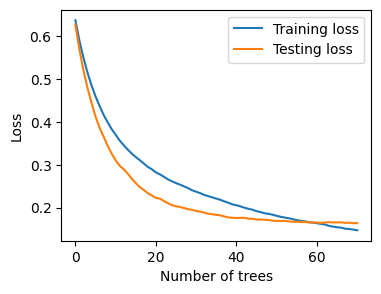

In [254]:
mod_xgb = xgb.XGBClassifier(booster="gbtree", objective='binary:logistic', 
                                eval_metric = 'logloss',
                                random_state=77,
                                n_estimators= xgb_it, 
                                **xgb_params  # use ** to unpack dict
                               ) 
mod_xgb.fit(x_train, y_train, verbose=0,
            eval_set=[(x_train, y_train), (x_test, y_test)])
results = mod_xgb.evals_result()
plt.figure(figsize=(4,3))
plt.plot(results["validation_0"]["logloss"], label="Training loss")
plt.plot(results["validation_1"]["logloss"], label="Testing loss")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [261]:
result_xgb = {'train_pred':mod_xgb.predict(x_train), 'train_prob':mod_xgb.predict_proba(x_train)[:,1],
  'test_pred':mod_xgb.predict(x_test), 'test_prob':mod_xgb.predict_proba(x_test)[:,1]}
dc.save_py(result_xgb, "output/result_xgb_imp")
# dc.load_py("output/result_xgb.pkl")
